## Train 'Class1' model on 224x224 px size instead of 150x150 px

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU


#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report

In [8]:
# Create two subsets, training and validation, of the 'Negative' and 'Positive' folders in the Training folder
# state directory to create subsets from
dir = '/home/becode/AI/Data/Skyebase/OpenSource' # 2 folders 'negative' and 'positive'
# create 'training' subset

# image size concrete pics = 227x227, I'll resize to 224x224 now(instead of 150x150) to hopefully het more acc on different datasets
# 224x224 is also the input size of vggnet that I'll use later 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
# create 'validation' subset, 20% of the total images for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)


Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [10]:
# flip and rotate images to create more diversity in small dataset, 'data augmentation' !!!!
data_augmentation = keras.Sequential(
    [
       RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [13]:
# prefetch to avoid I/O blocking
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# set params
batch_size = 64
epochs = 15 #30
num_classes = 1 # O or 1

In [14]:
# define model of Convolutional Neural Network
model = Sequential()
model.add(Rescaling(1./255, input_shape=(224,224,3))) # Rescaling is set up in the model itself !!!!!
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1)) # prevents blocked and non-active RELUs
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25)) # DROPOUT layer
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))  # DROPOUT layer
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.4)) # DROPOUT layer
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3)) # DROPOUT layer
model.add(Dense(num_classes, activation='sigmoid'))


In [15]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
print(model.summary())

# Train the model
model_train_dropout = model.fit(train_ds, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=val_ds)

# Save the model and the weights!
model.save("model_class1_224x224.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 75, 75, 64)       

Test loss: 0.02929505705833435
Test accuracy: 0.9933750033378601


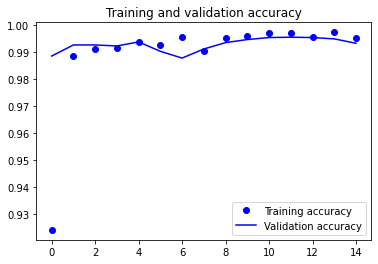

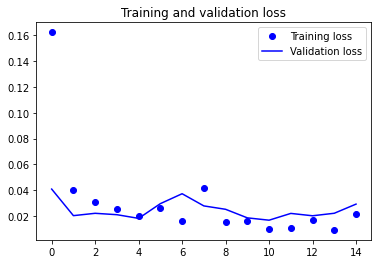

In [16]:
### Model Evaluation on validation set
# Evaluate Test set
test_eval = model.evaluate(val_ds, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Plot accuracy and loss plots
accuracy = model_train_dropout.history['accuracy']
val_accuracy = model_train_dropout.history['val_accuracy']
loss = model_train_dropout.history['loss']
val_loss = model_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()